In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle


Using TensorFlow backend.


In [2]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [3]:
DS.head()

,text_ID,word,tag
0,46809,RR,object
1,46809,130/80,object
2,46809,mmHg.,NaN
3,47482,"RR142/89mmHg,",object
4,47482,HR,NaN


In [4]:
DS['tag'].fillna('text', inplace=True)

In [5]:
words = list(set(DS["word"].values))
n_words = len(words); n_words

27741

In [6]:
tags = list(set(DS["tag"].values))
n_tags = len(tags); n_tags


2

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(DS)

In [9]:
sentences = getter.sentences


In [10]:
sentences[1]

[('Pt.', 'text'),
 ('tehtud', 'text'),
 ('3', 'text'),
 ('plasmaferees,', 'text'),
 ('talus', 'text'),
 ('hästi.', 'text'),
 ('Eemaldatud', 'text'),
 ('700', 'text'),
 ('ml', 'text'),
 ('plasmat.', 'text'),
 ('RR', 'object'),
 ('112/60', 'object'),
 ('mmHg.', 'text'),
 ('Tgasi', 'text'),
 ('22.10.09.', 'text')]

In [11]:
max([len(s) for s in DS.word])

54

In [12]:
max_len = 150
max_len_char = 10

In [13]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [14]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]


In [15]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [16]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


104


In [17]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [18]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [19]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]


In [20]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [21]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.2, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.2, random_state=2018)


In [22]:
max_len

150

In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=20,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=20, return_sequences=True,
                               recurrent_dropout=0.5))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)




In [24]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 10)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 150, 10, 20)  2120        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 20)      554860      input_1[0][0]                    
____________________________________________________________________________________________

In [25]:
X_word_tr.shape

(10914, 150)

In [26]:
X_char_tr[1].shape

(150, 10)

In [27]:
np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)).shape

(10914, 150, 10)

In [28]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 71s 7ms/step - loss: 0.0204 - acc: 0.9321 - val_loss: 0.0043 - val_acc: 0.9873
Epoch 2/10
9822/9822 [==============================] - 69s 7ms/step - loss: 0.0034 - acc: 0.9892 - val_loss: 0.0025 - val_acc: 0.9904
Epoch 3/10
9822/9822 [==============================] - 70s 7ms/step - loss: 0.0020 - acc: 0.9935 - val_loss: 0.0021 - val_acc: 0.9923
Epoch 4/10
9822/9822 [==============================] - 70s 7ms/step - loss: 0.0012 - acc: 0.9956 - val_loss: 0.0020 - val_acc: 0.9933
Epoch 5/10
9822/9822 [==============================] - 70s 7ms/step - loss: 6.4652e-04 - acc: 0.9974 - val_loss: 0.0020 - val_acc: 0.9930
Epoch 6/10
9822/9822 [==============================] - 70s 7ms/step - loss: 3.9461e-04 - acc: 0.9987 - val_loss: 0.0021 - val_acc: 0.9930
Epoch 7/10
9822/9822 [==============================] - 70s 7ms/step - loss: 3.0467e-04 - acc: 0.9989 - val_loss: 0.0021 - val_acc: 0.

In [29]:
hist = pd.DataFrame(history.history)


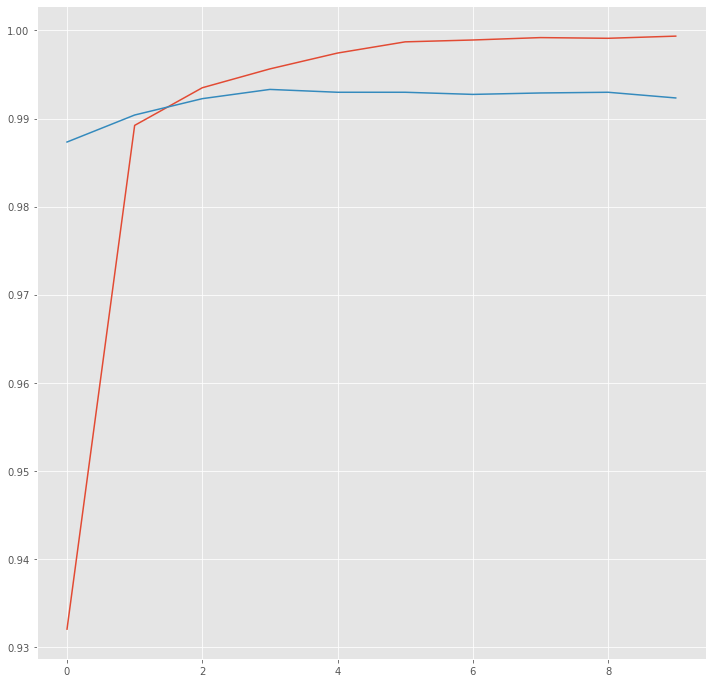

In [30]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [31]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])


In [32]:
i = 4
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
Kardiovaskulaarsüsteem:: text  text
RR             : object object
160/100mmHg.   : object object
Ausk-l         : text  text
s-toonid       : text  text
reg,           : text  text
puhtad,        : text  text
fr.            : text  text
60*min.        : text  text
Kardiovaskulaarsüsteem:: text  text
RR             : object object
160/100mmHg.   : object object
Ausk-l         : text  text
s-toonid       : text  text
reg,           : text  text
puhtad,        : text  text
fr.            : text  text
60*min.        : text  text


In [33]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p, axis=-1)
            out_i.append(idx2tag[p_i].replace("PAD","text"))
        out.append(out_i)
    return out
pred_labels = pred2label(y_pred)

def pred2labelV2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD","text"))
        out.append(out_i)
    return out
test_labels = pred2labelV2(y_te)

In [34]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0: #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
                j = j+1


puhtad.RR130/90: object text
/106           : text  object
/106           : text  object
ebaregulaarne,fr.87/min.RR-125/100: object text
157            : object text
*06.01.2015    : text  object
72/            : text  object
KORRAS.        : object text
KOORMUSTEST-KORRAS: object text
155/95         : object text
24-tunni       : object text
Pikkus-174cm,  : object text
Nõustamine.RR140/80: object text
.RR134/95      : object text
suhtes.RR140/80mmhg: object text
2.3.RR         : object text
kõikumised.RR  : object text
140-90mmhg     : object text
130/82         : object text
sööki.RR-136/74mmHG.: object text
/62            : text  object
sööki-6,6mmoll,RR-130/64mmHG.: object text
regulaarne,fr.68/min.RR-124/78: object text
P185           : text  object
176/102        : text  object
tarvitanud.RR  : object text
135/82         : object text
125.5/64.1     : object text
125.5/64.1     : object text
118            : object text
kahin.RR       : object text
112/81         : object text
f

In [35]:
j

266

In [36]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 87.1%


In [37]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

      object       0.09      0.95      0.16      3653
        text       1.00      0.91      0.95    405697

    accuracy                           0.91    409350
   macro avg       0.54      0.93      0.56    409350
weighted avg       0.99      0.91      0.95    409350



In [38]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))


F1-score: 87.1%
           precision    recall  f1-score   support

     text       0.93      0.87      0.90      4461
   object       0.82      0.81      0.81      2104

micro avg       0.90      0.85      0.87      6565
macro avg       0.90      0.85      0.87      6565



In [39]:
test_sentence = " Tupp vaba, em.kael puhas, RR 155/85 mmhg , emakas vÃ¤ike, adn.ii."
test_sentence = ''.join(test_sentence).split() 


In [40]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)


In [41]:
# y_pred = model.predict(x_test_sent,X_char_mytest)

# p = model.predict(x_test_sent)
# p = np.argmax(p, axis=-1)

# print("{:15}||{}".format("Word", "Prediction"))
# print(30 * "=")
# for w, pred in zip(test_sentence, p[0]):
#     print("{:15}: {:5}".format(w, tags[pred]))
